In [2]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import copy

# **The Hopfield Network**

**A Hopfield Network is a type of recurrent artificial neural network** that serves as a content-addressable memory system, meaning it can recall stored patterns from incomplete or noisy inputs. Introduced by John Hopfield in 1982 (but very similar ideas were already proposed by Kaoru Nakano in 1971 and Shun'ichi Amari in 1972), these networks are composed of a single layer of interconnected neurons, where each neuron is both an input and output, and connections between them are symmetric; for his foundational contributions to machine learning Hopfield has been awarded the 2024 Nobel Prize in Physics shared with Geoffrey Hinton.  

Hopfield networks store a set of memories $\{ X_i^{(\mu)} \}$ for $\mu \in [1, p]$ and $i \in [1, N]$, where $N$ is the number of pixels of a pattern and $p$ is the number of stored patterns.


In this notebook, **we will define a Python Class to initialise, evolve and visualise Hopfield Networks**. After writing this class, we will test some fundamental results of these networks, like the stability of its fixed points (i.e. the stored patterns). In the final part of the notebook a refined and modern version of the Hopfield Network will be introduced, that will allow us to obtain satisfying results also with more complex patterns. But first...

# A brief introduction to Python Classes 

We want to create a class called 'Hopfield Network' that initialise such a network and implements a variety of useful functions. In a nutshell, a class is a structure that holds together data and functions (called methods).

Classes can be a bit confusing at the beginning, but all you need to understand is that self means literary 'myself', that is, methods (functions) get as first argument the object they are acting on. This means that we can "store" a variable in one method and "retrieve" it in another! No need to pass it around!

Look at the following example code and play with it to make sure you understand how classes works.

In [6]:
class Model:
    # this is a special method that gets called when you create an instance of your class
    def __init__(self, name):
        self.name = name
    
    def set_x(self, x):
        self.x = x
        
    def increment_x(self):
        self.x += 1

    def show_x(self):
        return self.x

In [7]:
# Initialisation of two models
model1 = Model(name="my first model")
model2 = Model(name="another model")

In [8]:
# Using the methods implemented for the class 'Model'
model1.set_x(3)
model2.set_x(-2)

In [9]:
model1.show_x()

3

We can also access information stored in our objects. Notice that our models had a name that was set at initialization.

In [11]:
model1.name

'my first model'

Spend some time playing with this class by implementing new methods and trying them out.

# Exercise 6.1

Now that you have a basic understanding of Python classes, let's focus on Hopfield Networks. Start by creating 5 random patterns with shape 6x6 that the network will store and visualise them.

In [15]:
#Create 5 random patterns
N_patterns = 5
pattern_size = 6
# store the pattern in a dictionary
random_patterns = {f"pattern {i}": np.random.choice([-1,1], (pattern_size, pattern_size))for i in range(N_patterns)}


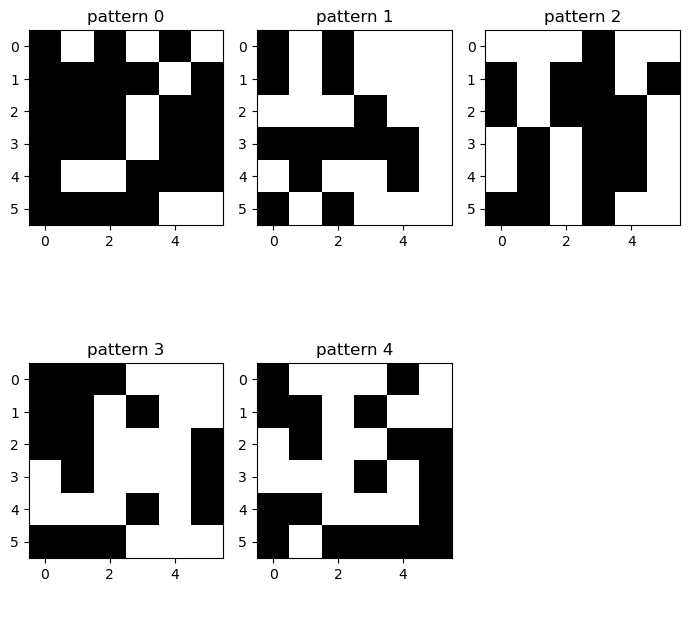

In [16]:
# visualise the patterns
fig, ax=plt.subplots(2,3, figsize=(7,7))
ax=ax.flatten()
for i, (name,pattern) in enumerate(random_patterns.items()):
    axes=ax[i]
    im=axes.imshow(pattern, cmap="gray", interpolation="none") #viridis è colormap continua
    axes.set_title(f"{name}")
    #fig.colorbar(im, ax=axes, orientation="vertical")  
ax[5].axis("off")
plt.tight_layout()
plt.show()

Let's start to build our HopfieldNetwork class. We start by defining the constructor and implementing a few basic methods that store important information such as:

* `HFN.patterns` is a matrix containing all the patterns in their original shape 
* `HFN.N_neurons` how many neurons the network has 
* `HFN.flat_patterns` is a matrix of stored _flattened_ patterns with shape *(N_patterns, N_neurons)*.
*  ...

In [1157]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """Initialises the Hopfield network with a set of patterns."""

       
        
        self.patterns_dict = patterns_dict# the entire dictionary
        
        self.pattern_names = {i: key for i, key in enumerate(patterns_dict.keys())}# the keys of the dictionary
        
        self.patterns = np.concatenate([patterns.flatten() for patterns in patterns_dict.values()]) # the patterns -> the values of the dictionary
        
        self.pattern_shape = next(iter(patterns_dict.values())).shape #the shape of each pattern
       
        # Some useful variables
        self.N_neurons = self.pattern_shape[0]*self.pattern_shape[1]
        self.N_patterns = len(self.pattern_names)
       
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = np.vstack([pattern.flatten() for pattern in patterns_dict.values()])


Now you can initialise you Hopfield Network! 

In [1160]:
# Call the class you just defined
HFN = HopfieldNetwork(random_patterns)


## Exercise 6.2

Let's store another important element: the weights matrix. Remember that the weights matrix is defined as $J_{ij} = \frac{1}{N}\sum_{\mu=1}^px_i^{\mu}x_j^{\nu}$. 

We copy the class previously written and we add the new lines; 'self.w' must store the weights matrix, with shape N x N, where N is the number of neurons.

In [1164]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """Initialises the Hopfield network with a set of patterns."""

       
        
        self.patterns_dict = patterns_dict# the entire dictionary
        
        self.pattern_names = {i: key for i, key in enumerate(patterns_dict.keys())}# the keys of the dictionary
        
        self.patterns = np.concatenate([patterns.flatten() for patterns in patterns_dict.values()]) # the patterns -> the values of the dictionary
        
        self.pattern_shape = next(iter(patterns_dict.values())).shape # the shape of each pattern
       
        # Some useful variables
        self.N_neurons = self.pattern_shape[0]*self.pattern_shape[1]
        self.N_patterns = len(self.pattern_names)
       
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = np.vstack([pattern.flatten() for pattern in patterns_dict.values()])

        
        # Initialise the weights and state of the network

        self.w = np.dot(self.flat_patterns.T, self.flat_patterns) / self.N_neurons
        np.fill_diagonal(self.w, 0) #mi assicuro che la diagonale sia nulla per escludere auto-interazioni
        
        

In [1166]:
HFN = HopfieldNetwork(random_patterns)

In [1168]:
### You can access and print the stored weights
print(HFN.w)


[[ 0.    0.01 -0.03 ...  0.01  0.03 -0.01]
 [ 0.01  0.    0.01 ...  0.01 -0.01 -0.01]
 [-0.03  0.01  0.   ...  0.01 -0.01  0.03]
 ...
 [ 0.01  0.01  0.01 ...  0.    0.03  0.03]
 [ 0.03 -0.01 -0.01 ...  0.03  0.    0.01]
 [-0.01 -0.01  0.03 ...  0.03  0.01  0.  ]]


## Exercise 6.3
We now define two new methods: *set_state* and *update_state*. 
*set_state* sets the state of the Hopfield network. We want the method to define the state as the pattern provided to the function.
If no pattern is provided, we define the state as a random pattern.
*update_state* updates the state of the network. The update can be asynchronous (one neuron updated at a time) or synchronous (all neurons updated at once)

In [1171]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """Initialises the Hopfield network with a set of patterns."""

       
        
        self.patterns_dict = patterns_dict# the entire dictionary
        
        self.pattern_names = {i: key for i, key in enumerate(patterns_dict.keys())}# the keys of the dictionary
        
        self.patterns = np.concatenate([patterns.flatten() for patterns in patterns_dict.values()]) # the patterns -> the values of the dictionary
        
        self.pattern_shape = next(iter(patterns_dict.values())).shape # the shape of each pattern
       
        # Some useful variables
        self.N_neurons = self.pattern_shape[0]*self.pattern_shape[1]
        self.N_patterns = len(self.pattern_names)
       
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = np.vstack([pattern.flatten() for pattern in patterns_dict.values()])
        #self.flat_patterns = np.column_stack([pattern.flatten() for pattern in patterns_dict.values()])

        # Initialise the weights and state of the network
        

        self.w = np.dot(self.flat_patterns.T, self.flat_patterns) / self.N_neurons
        np.fill_diagonal(self.w, 0) #mi assicuro che la diagonale sia nulla per escludere auto-interazioni
        self.set_state(random=True)  # initialises the state of the network 

        self.history={ "state":[],
                       "energy":[],
                       "similarities":[],
                      }
        return

    
    # =================== INITIALISE AND UPDATE NETWORK STATE  ======================
    
    def set_state(self, state=None, random=False):
        """Sets the state of the Hopfield network. If random = True, sets state to a random vector"""
        if random:
            self.state =np.random.choice([-1, 1], size=self.N_neurons)
        else:
            self.state = state

    def update_state(self, asynchronous=True):
        # asyncronous updates one neuron at a time
        if asynchronous == True:
            
            i = np.random.randint(0,self.N_neurons) # choose a random neuron

            self.state[i] = 1 if np.dot(self.w[i, :], self.state) >= 0 else -1   # update the neuron
            
        # synchronous updates all neurons at once
        elif asynchronous == False:
            
            self.state = np.where(np.dot(self.w, self.state) >= 0, 1, -1)



In [1173]:
HFN = HopfieldNetwork(random_patterns)

## Exercise 6.4 
Implement two new methods: 'get_similarities' and 'get_energy'. You just need to complete the new methods inserted below, read the initial comment to better understand what you have to do.


In [769]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """Initialises the Hopfield network with a set of patterns."""

       
        
        self.patterns_dict = patterns_dict# the entire dictionary
        
        self.pattern_names = {i: key for i, key in enumerate(patterns_dict.keys())}# the keys of the dictionary
        
        self.patterns = np.concatenate([patterns.flatten() for patterns in patterns_dict.values()]) # the patterns -> the values of the dictionary
        
        self.pattern_shape = next(iter(patterns_dict.values())).shape # the shape of each pattern
       
        # Some useful variables
        self.N_neurons = self.pattern_shape[0]*self.pattern_shape[1]
        self.N_patterns = len(self.pattern_names)
       
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = np.vstack([pattern.flatten() for pattern in patterns_dict.values()])

        # Initialise the weights and state of the network
        self.w = np.dot(self.flat_patterns.T, self.flat_patterns) / self.N_neurons
        np.fill_diagonal(self.w, 0) #mi assicuro che la diagonale sia nulla per escludere auto-interazioni
        self.set_state(random=True)  # initialises the state of the network 

    # =================== INITIALISE AND UPDATE NETWORK STATE  ======================
    
    def set_state(self, state=None, random=False):
        """Sets the state of the Hopfield network. If random = True, sets state to a random vector"""
        if random:
            self.state =np.random.choice([-1, 1], size=self.N_neurons)
        else:
            self.state = state

    def update_state(self, asynchronous=True):
        # asyncronous updates one neuron at a time
        if asynchronous == True:
            
            i = np.random.randint(0,self.N_neurons) # choose a random neuron

            self.state[i] = 1 if np.dot(self.w[i, :], self.state) >= 0 else -1
          
        elif asynchronous == False:
            
            self.state = np.where(np.dot(self.w, self.state) >= 0, 1, -1)

            




    def get_similarities(self, state=None):
        """Compares the state (defaults to the current state of the network to all stored patterns and returns a measure of similarity between the current state and each stored pattern.
        This measure is taken as cos(theta) where theta is the angle between the current state vector and the stored pattern vector in N-D space. 
        You basically perform a dot product between your state and each one of the stored patterns, divided by the norm of your state and by the norm of the stored pattern.
        """
        state=self.state if state is None else state
        cos_theta=np.zeros(self.N_patterns)
        for i in range(self.N_patterns):
            
            norm_state = np.sqrt(np.dot(state, state))
            norm_pattern = np.sqrt(np.dot(self.flat_patterns[i, :], self.flat_patterns[i, :]))
            if norm_state == 0 or norm_pattern == 0:
                cos_theta[i] = 0  # Similarità nulla se uno dei vettori è nullo
            else:
                cos_theta[i] = np.dot(state, self.flat_patterns[i, :]) / (norm_state * norm_pattern)


        return cos_theta

    
    def get_energy(self, state=None):
        """Returns the energy of the network at a given state"""
        #E=-1/2 S^TJS
        state = self.state if state is None else state
        energy=-0.5*np.dot(np.dot(state.T, self.w), state)
        return energy



## Exercise 6.5
Let's define a new method 'save_history' which saves some info inside a new variable called 'history'. 
This history must be updated, so you need to implement new lines also in other methods: 'set_state'and 'update_state'.

In [774]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """Initialises the Hopfield network with a set of patterns."""

       
        
        self.patterns_dict = patterns_dict# the entire dictionary
        
        self.pattern_names = {i: key for i, key in enumerate(patterns_dict.keys())}# the keys of the dictionary
        
        self.patterns = np.concatenate([patterns.flatten() for patterns in patterns_dict.values()]) # the patterns -> the values of the dictionary
        
        self.pattern_shape = next(iter(patterns_dict.values())).shape # the shape of each pattern
       
        # Some useful variables
        self.N_neurons = self.pattern_shape[0]*self.pattern_shape[1]
        self.N_patterns = len(self.pattern_names)
       
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = np.vstack([pattern.flatten() for pattern in patterns_dict.values()])

        # Initialise the weights and state of the network
        self.w = np.dot(self.flat_patterns.T, self.flat_patterns) / self.N_neurons
        np.fill_diagonal(self.w, 0) #mi assicuro che la diagonale sia nulla per escludere auto-interazioni
        self.set_state(random=True)  # initialises the state of the network 

        self.history={ "state":[],
                       "energy":[],
                       "similarities":[],
                      }
        return

    
    # =================== INITIALISE AND UPDATE NETWORK STATE  ======================
    
    def set_state(self, state=None, random=False):
        """Sets the state of the Hopfield network. If random = True, sets state to a random vector"""
        if random:
            self.state =np.random.choice([-1, 1], size=self.N_neurons)
        else:
            self.state = state

    def update_state(self, asynchronous=True):
        # asyncronous updates one neuron at a time
        if asynchronous == True:
            
            i = np.random.randint(0,self.N_neurons) # choose a random neuron

            self.state[i] = 1 if np.dot(self.w[i, :], self.state) >= 0 else -1
         
        elif asynchronous == False:
            
            self.state = np.where(np.dot(self.w, self.state) >= 0, 1, -1)





    def get_similarities(self, state=None):
        """Compares the state (defaults to the current state of the network to all stored patterns and returns a measure of similarity between the current state and each stored pattern.
        This measure is taken as cos(theta) where theta is the angle between the current state vector and the stored pattern vector in N-D space. 
        You basically perform a dot product between your state and each one of the stored patterns, divided by the norm of your state and by the norm of the stored pattern.
        """

        state=self.state if state is None else state
        cos_theta=np.zeros(self.N_patterns)
        for i in range(self.N_patterns):
            
            norm_state = np.sqrt(np.dot(state, state))
            norm_pattern = np.sqrt(np.dot(self.flat_patterns[i, :], self.flat_patterns[i, :]))
            if norm_state == 0 or norm_pattern == 0:
                cos_theta[i] = 0  # Similarità nulla se uno dei vettori è nullo
            else:
                cos_theta[i] = np.dot(state, self.flat_patterns[i, :]) / (norm_state * norm_pattern)


        return cos_theta
        self.save_history()
    
    def get_energy(self, state=None):
        """Returns the energy of the network at a given state"""
        #E=-1/2 S^TJS
        state = self.state if state is None else state
        energy=-0.5*np.dot(np.dot(state.T, self.w), state)
        return energy
        self.save_history()  # this saves the history of the network so we can analyse it later once it's all been done

    # =================== ANALYSIS AND HISTORY FUNCTIONS ======================
    def save_history(self):
        
        """Calculates energy and similarites then saves everything to the history of the Hopfield network"""
        
        self.similarities = self.get_similarities()
        self.energy = self.get_energy()
        
        """Now save the state, the similarities and the energy inside the new 'history variable' defined in the constructor"""
        
        self.history["state"].append(self.state.copy())
        self.history["similarities"].append(self.similarities)
        self.history["energy"].append(self.energy)



## Exercise 6.6
We are almost done creating our class! Let's add just a few methods to visualise the results. In the file 'utils.py' you'll find three functions already implemented, so you do not need to write the code yourself. You can import those functions and use them to define three new methods for your class. 

In [777]:
#### IMPORT THE FUCTIONS DEFINED IN 'utils.py' ####

from utils import * 

In [842]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """Initialises the Hopfield network with a set of patterns."""

       
        
        self.patterns_dict = patterns_dict# the entire dictionary
        
        self.pattern_names = {i: key for i, key in enumerate(patterns_dict.keys())}# the keys of the dictionary
        
        self.patterns = np.concatenate([patterns.flatten() for patterns in patterns_dict.values()]) # the patterns -> the values of the dictionary
        
        self.pattern_shape = next(iter(patterns_dict.values())).shape # the shape of each pattern
       
        # Some useful variables
        self.N_neurons = self.pattern_shape[0]*self.pattern_shape[1]
        self.N_patterns = len(self.pattern_names)
       
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = np.vstack([pattern.flatten() for pattern in patterns_dict.values()])
        

        self.history={ "state":[],
                       "energy":[],
                       "similarities":[],
                      }
        
        # Initialise the weights and state of the network
        self.w = np.dot(self.flat_patterns.T, self.flat_patterns) / self.N_neurons
        np.fill_diagonal(self.w, 0) #mi assicuro che la diagonale sia nulla per escludere auto-interazioni
        self.set_state(random=True)  # initialises the state of the network 

        return 
    
    # =================== INITIALISE AND UPDATE NETWORK STATE  ======================
    
    def set_state(self, state=None, random=False):
        """Sets the state of the Hopfield network. If random = True, sets state to a random vector"""
        if random:
            self.state =np.random.choice([-1, 1], size=self.N_neurons)
        else:
            self.state = state
        self.save_history()

    
    def update_state(self, asynchronous=True):
        # asyncronous updates one neuron at a time
        if asynchronous == True:
                    
            i = np.random.randint(0,self.N_neurons) # choose a random neuron

            self.state[i] = 1 if np.dot(self.w[i, :], self.state) >= 0 else -1
                    # synchronous updates all neurons at once
        elif asynchronous == False:
            
            self.state = np.where(np.dot(self.w, self.state) >= 0, 1, -1)
        self.save_history()




    def get_similarities(self, state=None):
        """Compares the state (defaults to the current state of the network to all stored patterns and returns a measure of similarity between the current state and each stored pattern.
        This measure is taken as cos(theta) where theta is the angle between the current state vector and the stored pattern vector in N-D space. 
        You basically perform a dot product between your state and each one of the stored patterns, divided by the norm of your state and by the norm of the stored pattern.
        """
        state=self.state if state is None else state
        cos_theta=np.zeros(self.N_patterns)
        for i in range(self.N_patterns):
            
            norm_state = np.sqrt(np.dot(state, state))
            norm_pattern = np.sqrt(np.dot(self.flat_patterns[i, :], self.flat_patterns[i, :]))
            if norm_state == 0 or norm_pattern == 0:
                cos_theta[i] = 0  # Similarità nulla se uno dei vettori è nullo
            else:
                cos_theta[i] = np.dot(state, self.flat_patterns[i, :]) / (norm_state * norm_pattern)


        return cos_theta
        self.save_history()
    
    def get_energy(self, state=None):
        """Returns the energy of the network at a given state"""
        #E=-1/2 S^TJS
        state = self.state if state is None else state
        energy=-0.5*np.dot(np.dot(state.T, self.w), state)
        return energy
        self.save_history()  # this saves the history of the network so we can analyse it later once it's all been done

    # =================== ANALYSIS AND HISTORY FUNCTIONS ======================
    def save_history(self):
        """Calculates energy and similarites then saves everything to the history of the Hopfield network"""
        self.similarities = self.get_similarities()
        self.energy = self.get_energy()
        """Now save the state, the similarities and the energy inside the new 'history variable' defined in the constructor"""
        self.history["state"].append(self.state.copy())
        self.history["similarities"].append(self.similarities)
        self.history["energy"].append(self.energy)




    

    # =================== PLOTTING FUNCTIONS ==============================

    
    def visualise(self, steps_back=0, fig=None, ax=None, title=None):
        """Visualises the state of the Hopfield network n_steps back (defaults to steps_back=0, i.e. current state)"""
        fig, ax = visualise_hopfield_network( self, steps_back=0, fig=None, ax=None, title=title)
        return fig, ax

    def plot_energy(self, n_steps=None):
        """Plots the energy of the Hopfield network over time. n_steps=None defaults to _all_ steps"""
        fig, ax = plot_energy(self, n_steps=None)
        return fig, ax

    def animate(self, n_steps=10, fps=10, animation_length_secs=5):
        """Animates the last n_steps of the Hopfield network. fps gives frames per socond of resulting animation"""
        anim = animate_hopfield_network(self, n_steps=10, fps=10, animation_length_secs=5)

        return anim

## Exercise 6.7

In class we proved that the stored patterns are fixed points of the dynamics, meaning that the system will evolve towards one of the stored patterns starting from any configuration. In particular, if the system is initialised as one of the stored states, it will stay in that configuration. Check if this is true by visualising the starting state and the state after several updates (apply several times the *update_state* method that you defined). You can also check that the energy of the system is constant. Use the *visualise* and *plot_energy* methods that you defined in your class.

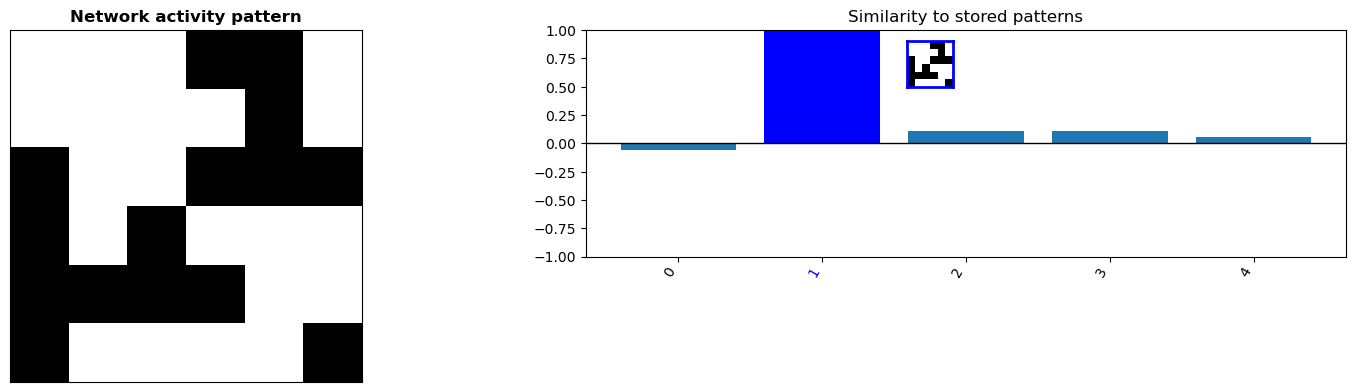

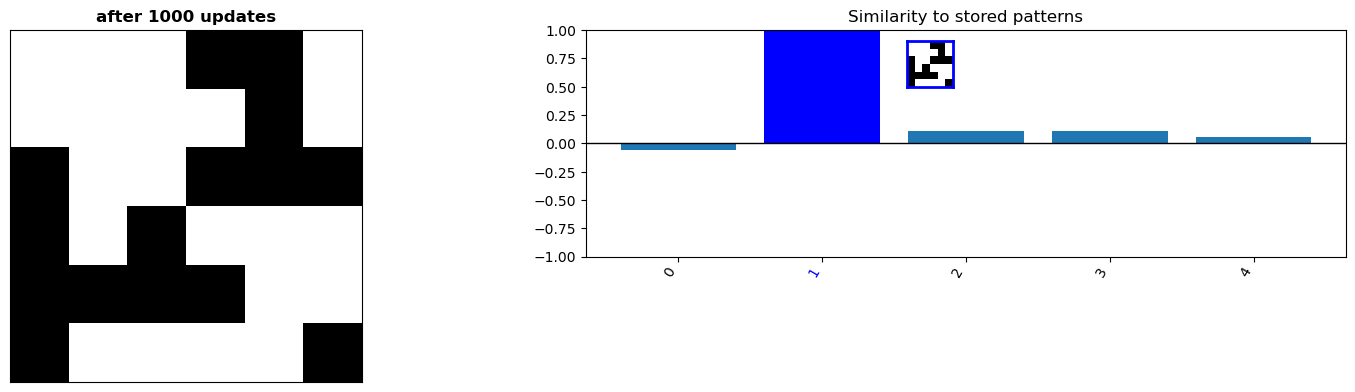

In [876]:
n_patterns=5
pattern_size = 6
n_updates=1000


patterns= {i: np.random.choice([-1,1], (pattern_size, pattern_size)) for i in range (n_patterns)} #creo memoria random
#inizializzo la rete
HFN=HopfieldNetwork(patterns) 
#parto da un pattern casuale tra quelli salvati e mostro che la rete rimane su esso anche dopo l'evoluzione
initial_pattern = list(patterns.values())[np.random.randint(0,len(patterns))].flatten()  
HFN.set_state(initial_pattern)
HFN.visualise()
#evolvo il sistema
for i in range(n_updates):
    HFN.update_state()

HFN.visualise(title=f"after {n_updates} updates")
plt.show()


n_steps: None
n_steps: 1000


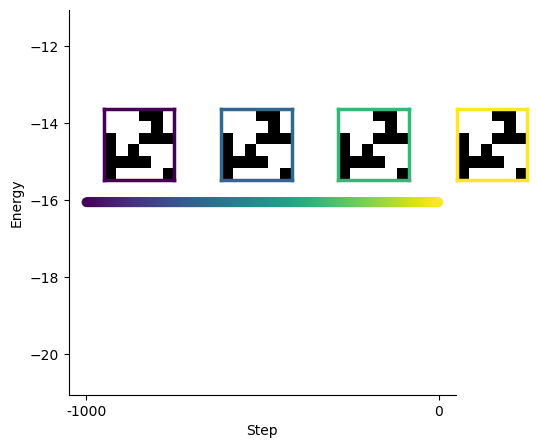

In [878]:
### You can also visualise the time evolution of the energy function

fig, ax = HFN.plot_energy(n_steps=200)

## Exercise 6.8

Do the same but starting from a random configuration. Check that the system evolves towards one of the stored patterns and that the energy decreases until a minimum is reached.

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'after 1000 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

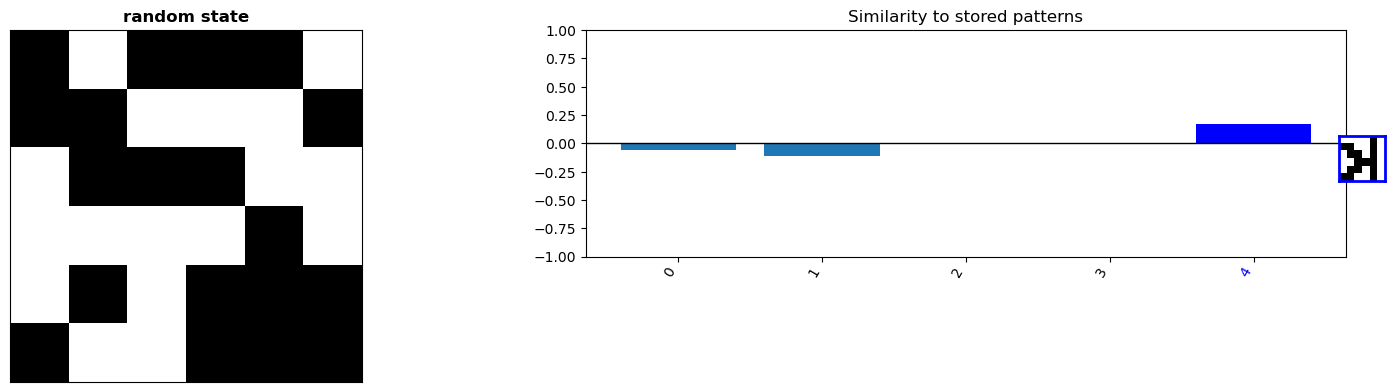

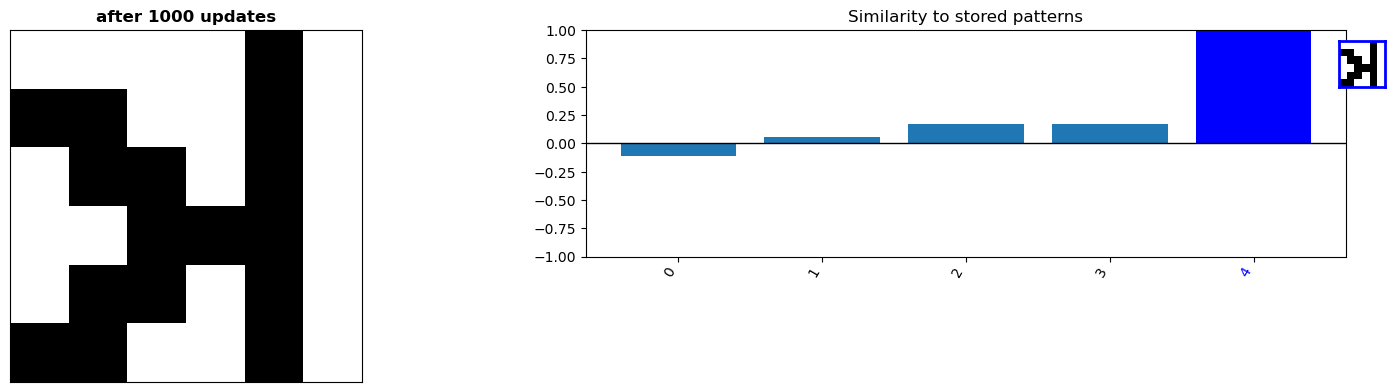

In [904]:
HFN=HopfieldNetwork(patterns)
#imposto stato casuale e visualizzo
HFN.set_state(random=True)
HFN.visualise(title="random state")

#evolvo
for i in range(n_updates):
    HFN.update_state()

HFN.visualise(title=f"after {n_updates} updates")

# IMAGE RECOGNITION

## Exercise 6.9

One of the applications of the Hopfield Network is image recognition. By starting from a pattern which is 'similar' to one of the stored ones, the system should evolve towards that state; it is essentially 'recognising' the picture. Try to add some 'noise' to one of the stored patterns and then use this noisy pattern as the starting state. Check that the network correctly evolves towards the right pattern. At what level of noise the network starts to fail? 

In [908]:
def apply_noise(pattern, percentage=None):
    #di default imposto la percentuale di rumore al 20%
    percentage= 20 if percentage is None else percentage

    pattern_size=pattern.shape[0]*pattern.shape[1]

    n_flips=round(pattern_size/100*percentage)#converto la percentuale di rumore in numero di flip da eseguire
    
    already_flipped_cells=[]
    
    for i in range(n_flips):
        rand_row=np.random.randint(0,pattern.shape[0], size=1) #ho generalizzato a pattern non quadrati, complicando leggermente la sintassi
        rand_col= np.random.randint(0,pattern.shape[1], size=1)
        while (rand_row, rand_col) in already_flipped_cells: #evito i doppi flip che non aggiungerebbero rumore
            rand_row=np.random.randint(0,pattern.shape[0],size=1)
            rand_col=np.random.randint(0,pattern.shape[1],size=1)
    
        pattern[rand_row,rand_col]*=-1 #flip di un neurone casuale
        already_flipped_cells.append((rand_row,rand_col))#lo aggiungo a quelli gia flippati



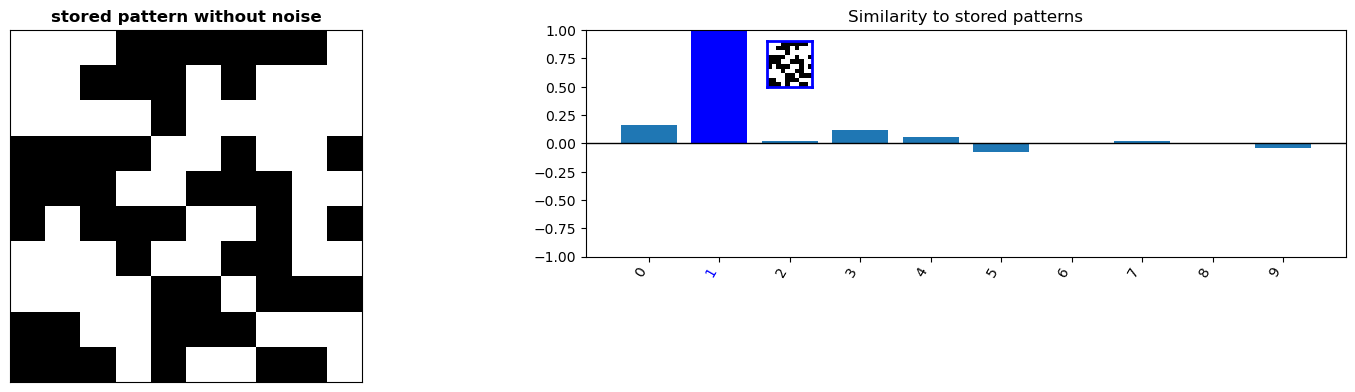

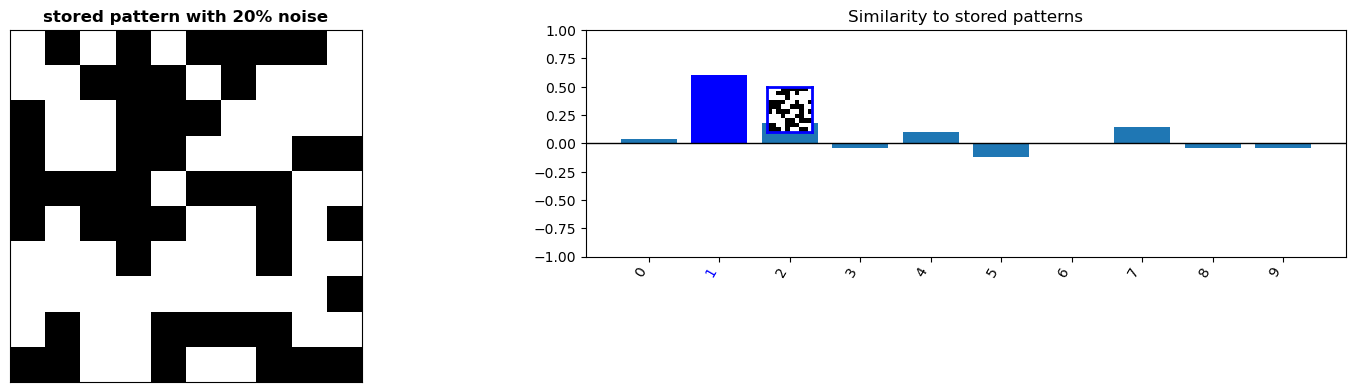

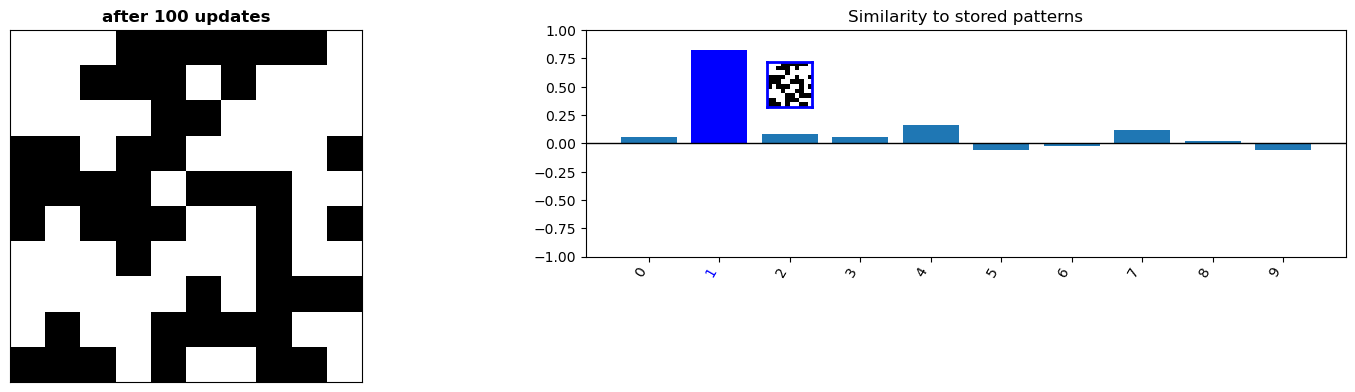

In [912]:
pattern_size = 10
n_updates=100
N_patterns=10
memorized_patterns={i: np.random.choice([-1,1], (pattern_size,pattern_size)) for i in range (N_patterns)}
pattern_to_start = memorized_patterns[np.random.randint(0,N_patterns)] #prendo un pattern a caso tra quelli memorizzati

#add some noise to the starting pattern
noisy_state=pattern_to_start.copy()
apply_noise(noisy_state)

HFN=HopfieldNetwork(memorized_patterns)
HFN.set_state(pattern_to_start.flatten())
HFN.visualise(title="stored pattern without noise")
HFN.set_state(noisy_state.flatten())
fig, ax=HFN.visualise(title="stored pattern with 20% noise")

for i in range(n_evolutions):
    HFN.update_state()
    
fig, ax=HFN.visualise(title=f"after {n_updates} updates")
plt.show()
#the network starts to fail at about 35/40% noise

## Exercise 6.10

Can the Hopfield Network recognise an image if only a small part of it is provided? For instance, is it able to recognise an image if we provide only the upper left corner? To check, you first need to write a function that masks the given pattern. Complete the function below and then use it to check if the network can recognise one of the stored patterns using only one corner.

In [916]:
def apply_mask(pattern, mask_amount=None):
    """Masks 75% of the pattern, by setting to zero all the elements of the pattern except the top-left corner"""
    
    mask = np.zeros((pattern.shape[0], pattern.shape[1]))

    
    mask_amount=75 if mask_amount is None else mask_amount #percentuale da mascherare, di default è quella del testo
    for row in range (pattern.shape[0]):
        for col in range(pattern.shape[1]):
            if row>(pattern.shape[0]*mask_amount/100) and col>np.floor(pattern.shape[1]*(1-mask_amount/100)):
                mask[row,col]=0
            elif row<=pattern.shape[0]*(1-mask_amount/100) and col<=np.floor(pattern.shape[1]*(1-mask_amount/100)):
                mask[row,col]=1
    
    return pattern * mask
    #test
masked=apply_mask(pattern_to_start)
print(masked)

[[ 1.  1.  1. -0. -0. -0. -0. -0. -0.  0.]
 [ 1.  1. -1. -0. -0.  0. -0.  0.  0.  0.]
 [ 1.  1.  1.  0. -0.  0.  0.  0.  0.  0.]
 [-0. -0. -0. -0.  0.  0. -0.  0.  0. -0.]
 [-0. -0. -0.  0.  0. -0. -0. -0.  0.  0.]
 [-0.  0. -0. -0. -0.  0.  0. -0.  0. -0.]
 [ 0.  0.  0. -0.  0.  0. -0. -0.  0.  0.]
 [ 0.  0.  0.  0. -0. -0.  0. -0. -0. -0.]
 [-0. -0.  0.  0. -0. -0. -0.  0.  0.  0.]
 [-0. -0. -0.  0. -0.  0.  0. -0. -0.  0.]]


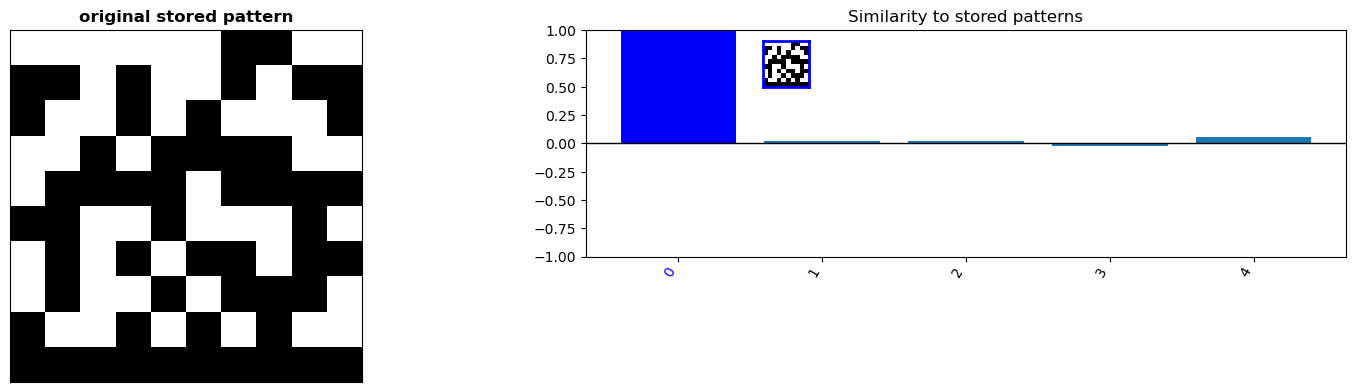

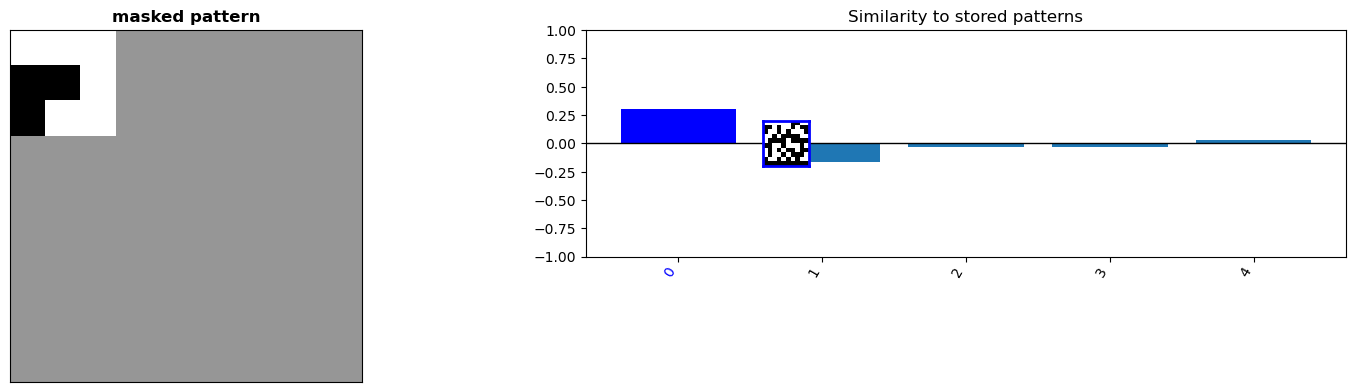

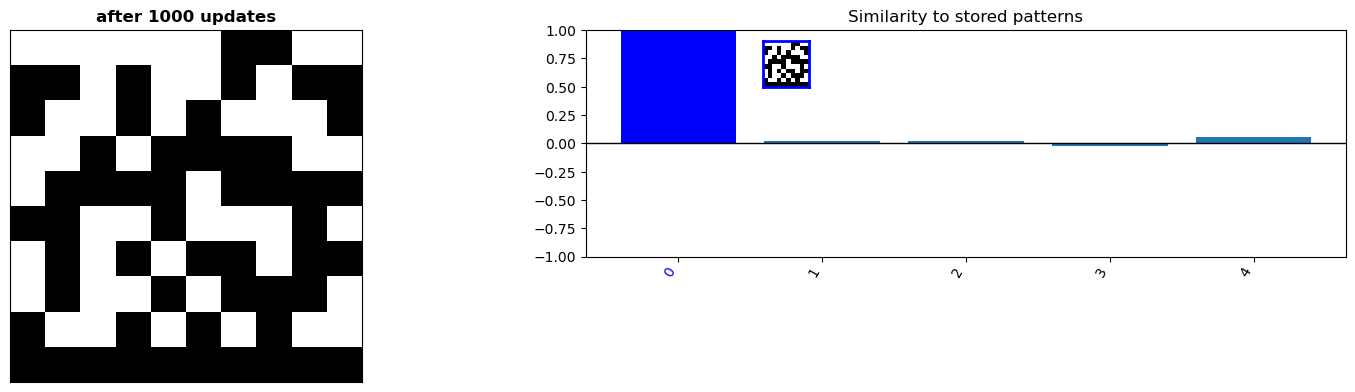

In [920]:
pattern_size = 10
n_updates=1000
N_patterns=5 #ho notato che con 10 pattern la rete fa molta più fatica a riconoscerlo... per una rete con 100 neuroni, la capacità di storage è circa 15, 10 quindi era troppo vicino al limite
memorized_patterns={i: np.random.choice([-1,1], (pattern_size,pattern_size)) for i in range (N_patterns)}
pattern_to_start = memorized_patterns[np.random.randint(0,N_patterns)]
#genero il pattern mascherato
partially_masked_pattern = apply_mask(pattern_to_start)

HFN=HopfieldNetwork(memorized_patterns)
HFN.set_state(pattern_to_start.flatten())
HFN.visualise(title="original stored pattern")
HFN.set_state(partially_masked_pattern.flatten())
HFN.visualise(title="masked pattern")
for i in range(n_updates):
    HFN.update_state()
HFN.visualise(title=f"after {n_updates} updates")
plt.show()


### YOUR CODE HERE

## Exercise 6.11 
The stored patterns are not the only fixed points of our dynamics. Prove analytically that also the negatives of the stored patterns (defined by $-x_i^{\mu}$) are fixed points of the dynamics. Then, check numerically the validity of this claim by starting from the negative of a stored pattern and evolving the system.

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'after 1000 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

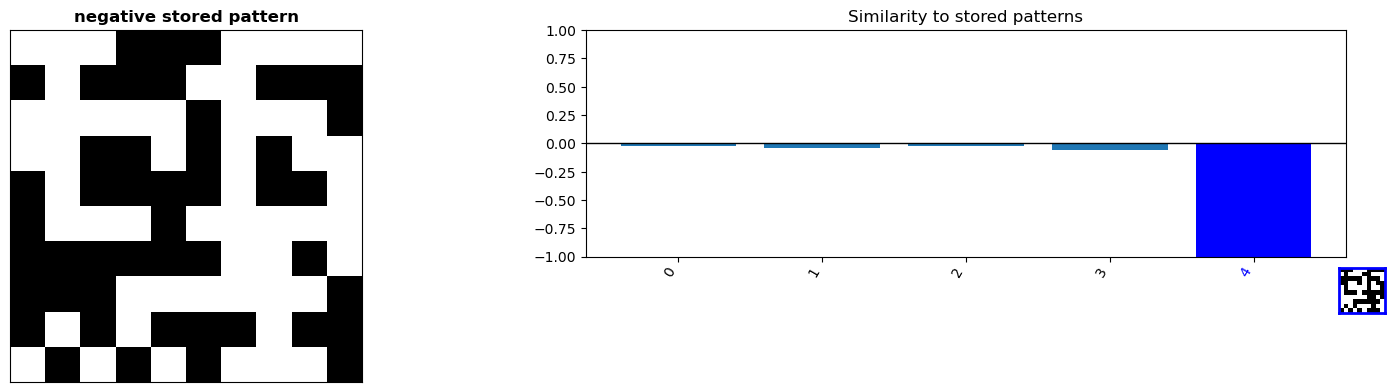

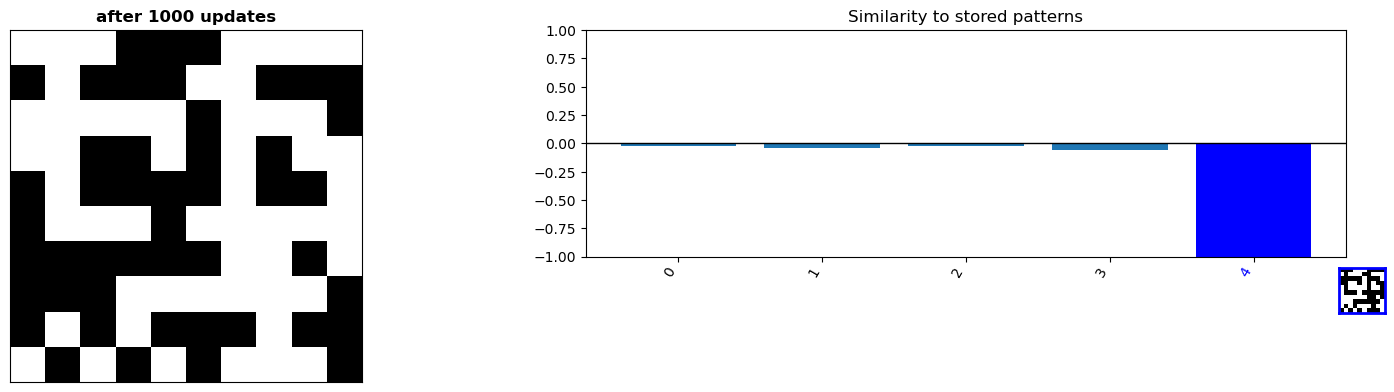

In [924]:

memorized_patterns={i: np.random.choice([-1,1], (pattern_size,pattern_size)) for i in range (N_patterns)}

pattern = memorized_patterns[np.random.randint(0,N_patterns)]

negative_pattern = -1*pattern

HFN=HopfieldNetwork(memorized_patterns)

HFN.set_state(negative_pattern.flatten())


HFN.visualise(title="negative stored pattern")
for i in range(n_evolutions):
    HFN.update_state()
HFN.visualise(title=f"after {n_updates} updates") #mostro che se è in uno stato negativo, ci rimane in quanto punto fisso della dinamica della rete


# Exercise 6.12 

What happens if we try to initialise the network in a mixed state? For example and mix of patterns 1, 2 and 3: 

$$ s_i(0) := x_i^{\textrm{mix}} = \textrm{sgn} \big( \pm x_i^{(1)} \pm x_i^{(2)} \pm x_i^{(3)} \big)$$


(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'after 100000 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

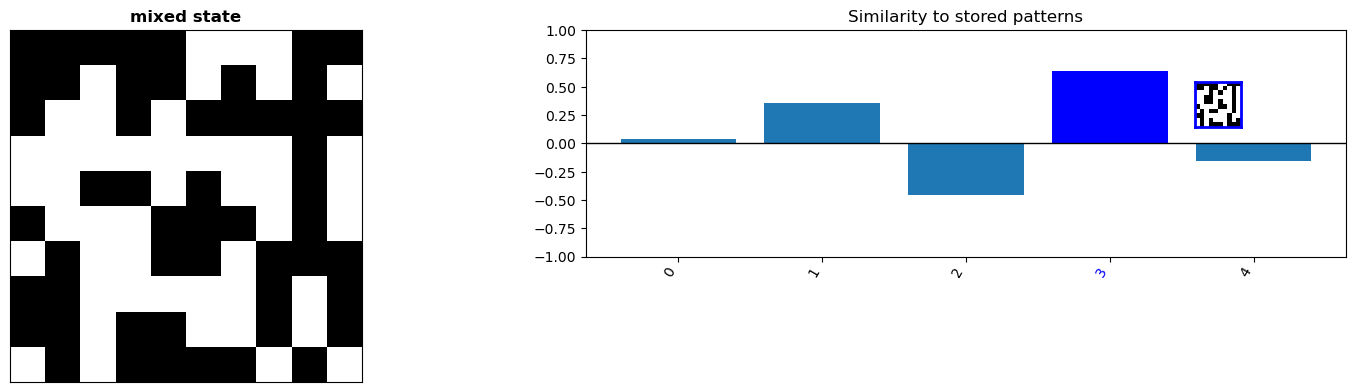

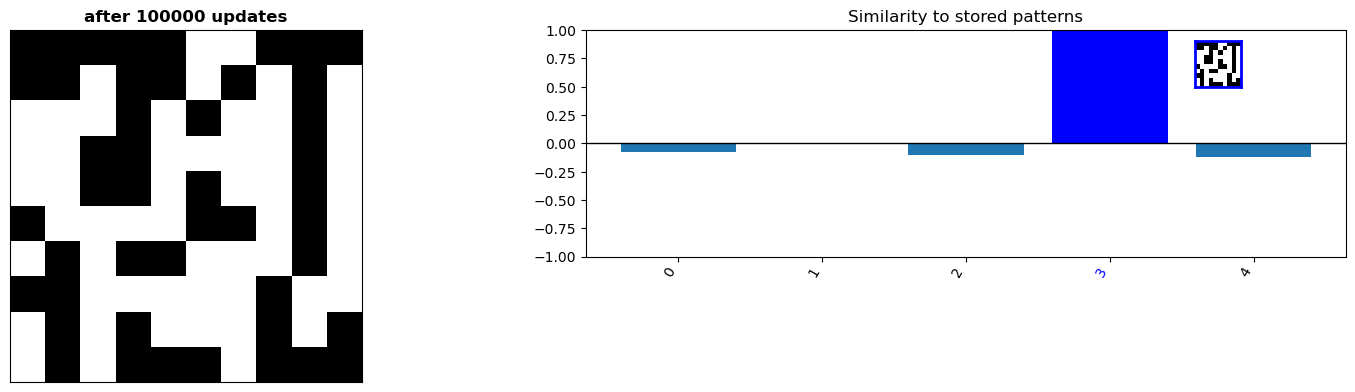

In [961]:
##### define a mixed state
n_updates=100000
random_patterns={i: np.random.choice([-1,1], (pattern_size,pattern_size)) for i in range (N_patterns)}
mixed_state = np.sign(random_patterns[1].flatten() - random_patterns[2].flatten() + random_patterns[3].flatten())
#reinitialise the state of the network, evolve it for several steps and then visualise 
HFN=HopfieldNetwork(random_patterns)
HFN.set_state(mixed_state)
HFN.visualise(title="mixed state")
for i in range(n_updates):
    HFN.update_state()
HFN.visualise(title=f"after {n_updates} updates")
#the network will evolve towards one of the mixed patterns

# Exercise 6.13

The Hopfield Network has a storage capacity, meaning that if the number of stored patterns is too high for the number of neurons, it will show issues in correctly retrieving the patterns. 

The storage capacity for a classical Hopfield Network can be estimated as $C\approx\frac{N}{2\log_2 N}$.

Test a Hopfield network with a number of stored patterns way higher than its capacity (for instance try to store 20 patterns with 4x4 pixels) and show that it fails in retrieving these patterns.

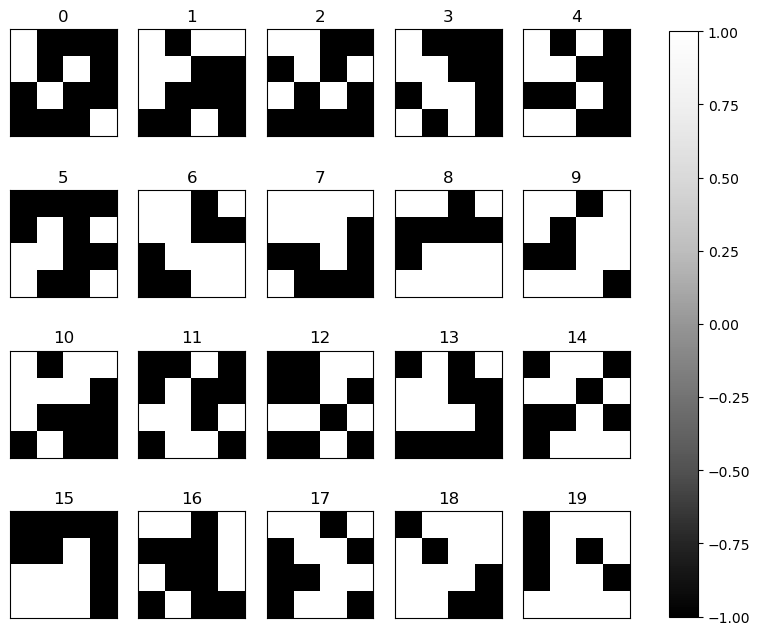

In [1035]:
#Create 20 random patterns of size 4x4
N_patterns = 20
pattern_size = 4
random_patterns_20 = {i: np.random.choice([-1,1], (pattern_size, pattern_size)) for i in range (N_patterns)}

fig, ax = plot_patterns(random_patterns_20)

HFN = HopfieldNetwork(random_patterns_20)

Not all the patterns are equally 'unstable', some of them will still act as fixed points, while other will not. Try different starting patterns among those stored and try to find a pattern which is 'stable' and one that is 'unstable'. 

pattern number 1 is ''unstable'' 
pattern number 2 is ''unstable'' 
pattern number 3 is ''unstable'' 
pattern number 4 is ''stable'' as it is a fixed point of the network's dynamics
pattern number 5 is ''unstable'' 
pattern number 6 is ''unstable'' 
pattern number 7 is ''unstable'' 
pattern number 8 is ''stable'' as it is a fixed point of the network's dynamics
pattern number 9 is ''unstable'' 
pattern number 10 is ''unstable'' 
pattern number 11 is ''unstable'' 
pattern number 12 is ''unstable'' 
pattern number 13 is ''stable'' as it is a fixed point of the network's dynamics
pattern number 14 is ''unstable'' 
pattern number 15 is ''unstable'' 
pattern number 16 is ''unstable'' 
pattern number 17 is ''stable'' as it is a fixed point of the network's dynamics
pattern number 18 is ''unstable'' 
pattern number 19 is ''unstable'' 
pattern number 20 is ''unstable'' 
in this case, stable patterns are 20.0% of the total stored ones 
 Here follows a visualization of the evolution of a stable 

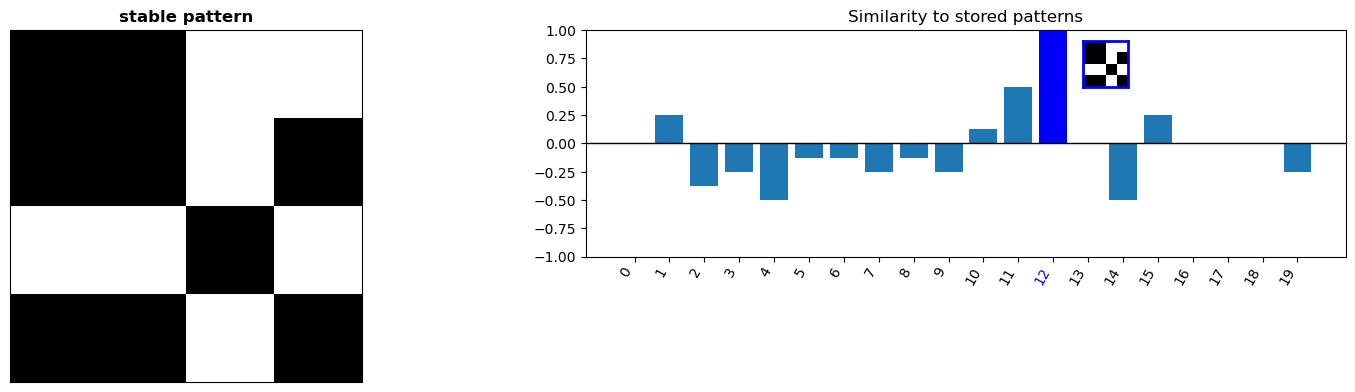

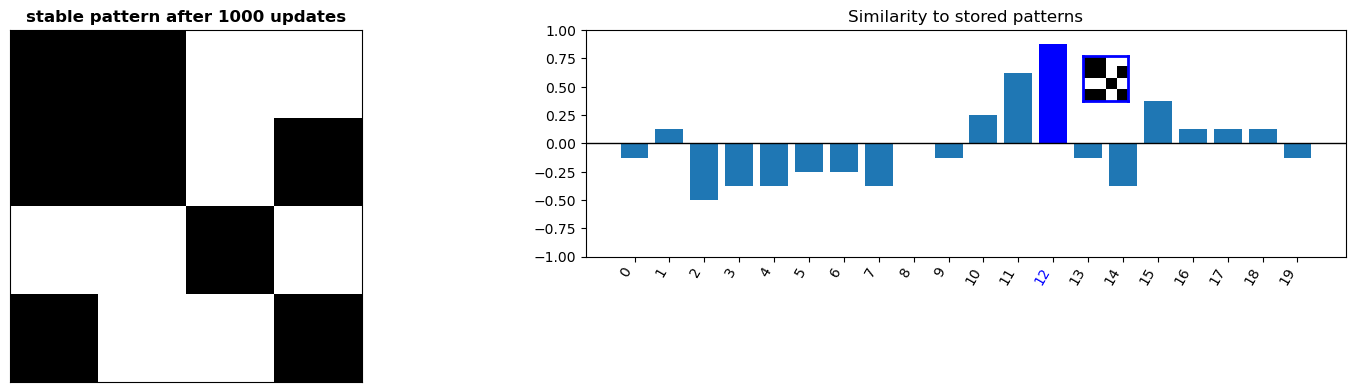

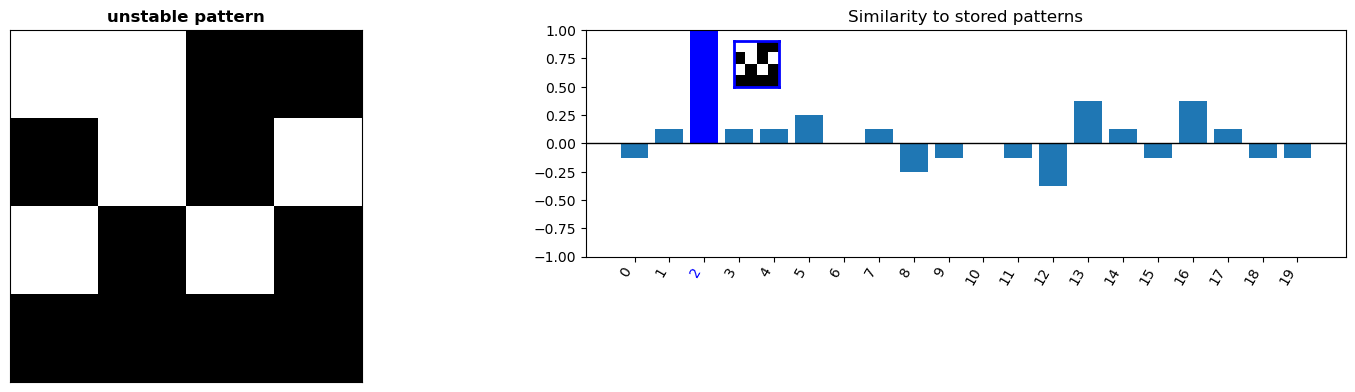

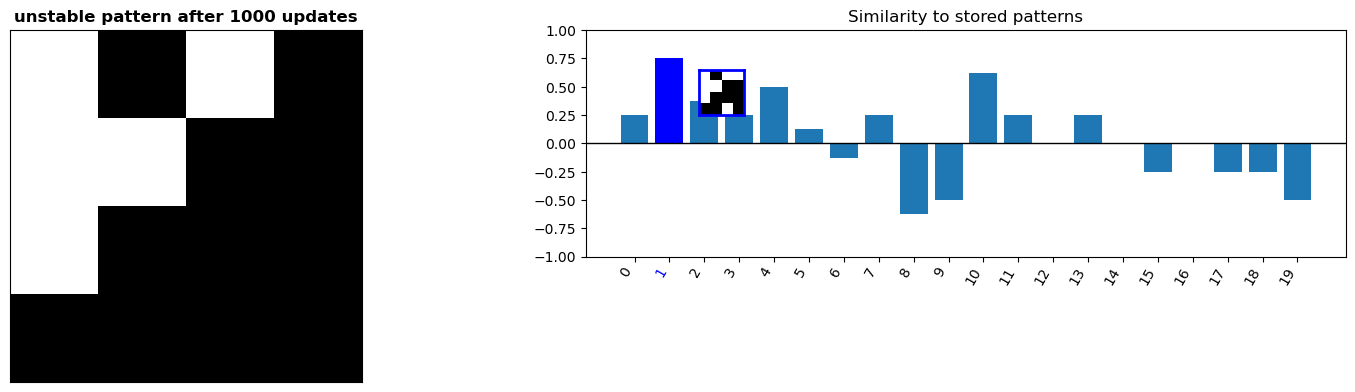

In [1044]:
# Try to start from all the stored patterns and find the stable or unstable ones.
n_updates=1000
stable_index=[]
unstable_index=[i for i in range (N_patterns+1)]
for i in range (N_patterns):
    HFN.set_state(random_patterns_20[i].flatten())
   
    for j in range (n_updates):
        HFN.update_state()
        
    if np.isclose(HFN.similarities[i],1, atol=0.2):
        print(f"pattern number {i+1} is ''stable'' as it is a fixed point of the network's dynamics")
        stable_index.append(i)
        unstable_index.remove(i)
    else:
        print(f"pattern number {i+1} is ''unstable'' ")
if not stable_index: #controllo se ho trovato pattern stabili
    print("no stable patterns found, please restart the network with new random patterns")
else:
    print(f"in this case, stable patterns are {len(stable_index)/N_patterns*100}% of the total stored ones \n Here follows a visualization of the evolution of a stable pattern and an unstable one:")
    
    HFN.set_state(random_patterns_20[np.random.choice(stable_index)].flatten())

    HFN.visualise(title="stable pattern")
    for i in range (n_updates):
        HFN.update_state()
  
    HFN.visualise(title=f"stable pattern after {n_updates} updates")
    
    HFN.set_state(random_patterns_20[np.random.choice(unstable_index)].flatten())

    HFN.visualise(title="unstable pattern")
    for i in range (n_updates):
        HFN.update_state()

    HFN.visualise(title=f"unstable pattern after {n_updates} updates")
    plt.show()





# The Classical Hopfield Networks fails with complex patterns


The network that we implemented is very good at recognising simple patterns, as long as you do not exceed the capacity of you network. But it will fail with more complex patterns.

In the next cell, we will load **more complex patterns**, namely a few sprites from the Pokemon videogames. These images are way bigger than the patterns previously used (120x112 pixels).

To convert the images from the *.png* format to matrices, we'll need a package called *openCV*. If not already installed on your system, you can easily install it by running

    pip install opencv-python

in your terminal.

In [1051]:
import cv2
import os

directory = os.fsencode("pokemon")  # Codifica della directory
patterns = {}  # Inizializza il dizionario

for file in os.listdir(directory):
    filename = os.fsdecode(file)  # Decodifica il nome del file

    # Filtra solo i file con estensione .png
    if filename.endswith(".png"):
        filepath = os.path.join("pokemon", filename)  # Costruzione corretta del percorso

        # Leggi l'immagine
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"L'immagine non è stata caricata correttamente: {filepath}")
        
        # Aggiungi l'immagine al dizionario
        patterns[filename[:-4]] = (img / 255) * 2 - 1
    else:
        print(f"File ignorato: {filename}")  # Ignora file non immagine



File ignorato: .ipynb_checkpoints


In [1053]:
# Initialise a new Hopfield network with the new patterns
HFN = HopfieldNetwork(patterns)

(<Figure size 1600x400 with 2 Axes>,
 array([<Axes: title={'center': 'State after 100 updates'}>,
        <Axes: title={'center': 'Similarity to stored patterns'}>],
       dtype=object))

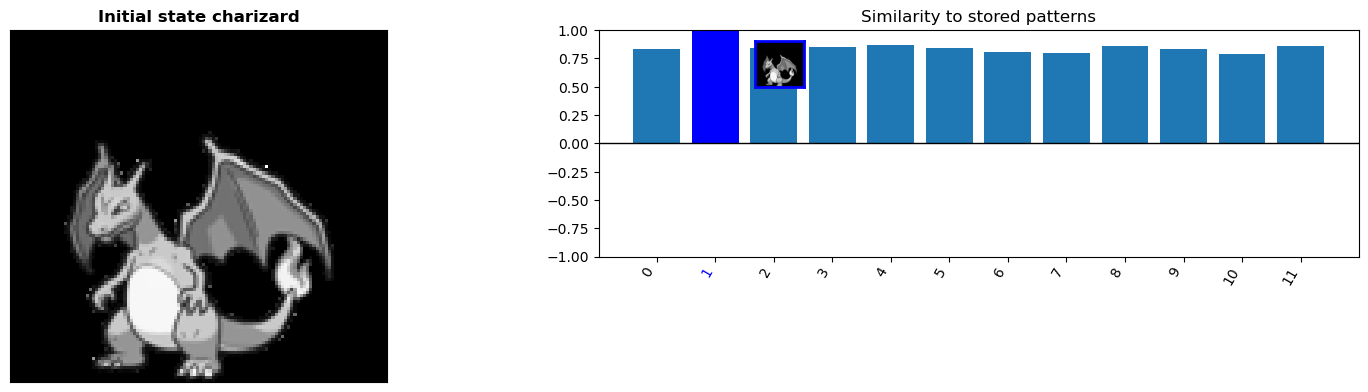

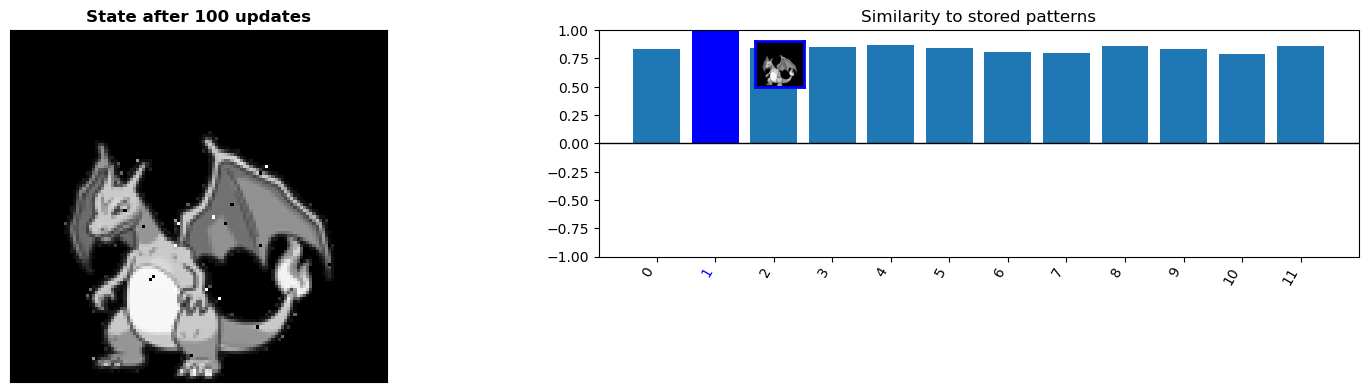

In [1059]:
pokemon = 'charizard'
n_updates=100
HFN.set_state(patterns[pokemon].flatten()) #reinitialise the state of the network
HFN.visualise(title=f"Initial state {pokemon}")

for i in range(n_updates):
    HFN.update_state(asynchronous=True)

HFN.visualise(title=f"State after {n_updates} updates")



n_steps: None
n_steps: 1100


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

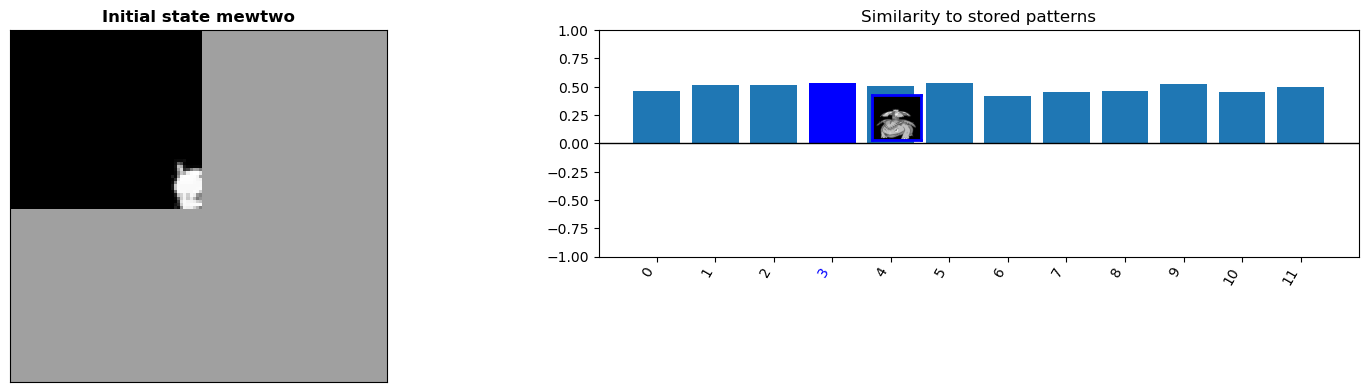

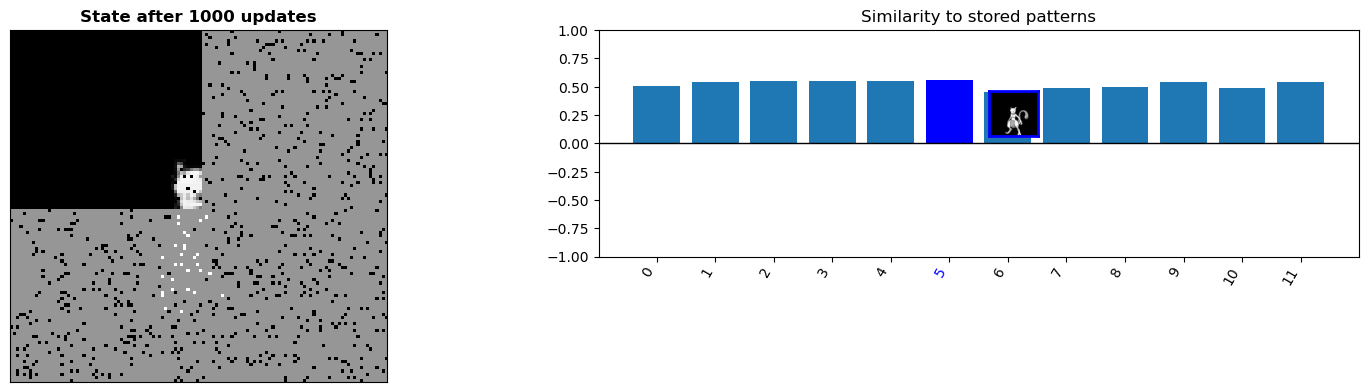

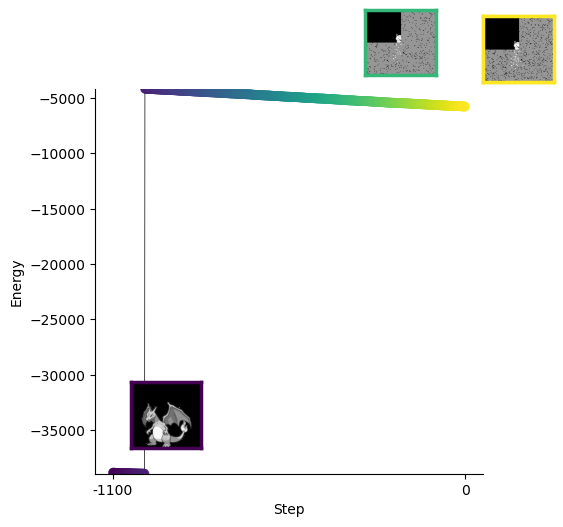

In [728]:
pokemon = 'mewtwo'
n_updates=1000
masked=apply_mask(patterns[pokemon], mask_amount=50)

HFN.set_state(masked.flatten()) #reinitialise the state of the network

HFN.visualise(title=f"Initial state {pokemon}")
for i in range(n_updates):
    HFN.update_state(asynchronous=True)

HFN.visualise(title=f"State after {n_updates} updates")

You'll soon realize that **our Hopfield Network is not doing great with these more complex patterns**. There are probably two main reasons: the patterns are not binary (they are grayscale images, not b
lack and white) and also they are **too correlated** , with a white/gray silhouette in the central-bottom part of the square surrounded by a large portion of black pixels.
It's time for an upgrade...

# Let's upgrade: Modern Hopfield Networks

The performances of the Hopfield Network can be greatly improved by just modifying the energy function and the update rule. 
The new rules are:

| | **Classic** | **Modern** |
| ----------- | ----------- | ----------- |
| **Update rule** | $ \vec{s} \leftarrow \textrm{sign}\big(\underbrace{\vec{x}\vec{x}^{\mathsf{T}}}_{\mathsf{J}}\vec{s}\big)$ | $\vec{s} \leftarrow \vec{x} \textrm{softmax}(\beta \vec{x}^{\mathsf{T}}\vec{s})$ |
| **Energy function** | $ E(\vec{s}) = \vec{s}^{\mathsf{T}}\underbrace{\vec{x}\vec{x}^{\mathsf{T}}}_{\mathsf{J}}\vec{s}$ | $E(\vec{s}) = -\textrm{lse}\big(\vec{x}^{\mathsf{T}}\vec{s}\big) + \frac{1}{2} \vec{s}^{\mathsf{T}}\vec{s}$ |

where the softmax function is defined as $\text{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^{K}e^{x_j}}$ and the log-sum-exp function is $\text{lse}(\mathbf{x})=\log(\sum_{i=0}^{K}e^{x_i})$.

# Exercise 6.14 

Implement the *softmax* and *lse* functions, then complete the new class *ModernHopfieldNetwork* by defining the new energy function and update rule.

Finally, test your new model on the complex patterns and show that, starting from a random pattern, the system correctly converge to one of the Pokemon sprites.

In [1127]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def log_sum_exp(x, beta=1):
    """l'implementazione "originale" mi dava errore di overflow. 
    Per evitare di dover avere a che fare con numeri troppo grandi tolgo il max dell'array a tutti gli elementi prima di fare l'esponenziale,poi
    lo riaggiungo fuori dal log. Questo mi da lo stesso risultato finale ed elimina gli errori"""
    xmax=np.max(x)
    return np.log(np.sum(np.exp(beta * (x-xmax)))) +xmax/beta


We want the new class to inherit all the methods from our original `HopfieldNetwork` class so we can use all the same plotting functions. Complete the *update_state* and *get_energy* methods.

In [1130]:
class ModernHopfieldNetwork(HopfieldNetwork):
    def __init__(self,patterns,beta=0.01):
        self.beta = beta
        super().__init__(patterns) #super fa ereditare il costruttore di HopfieldNetwork
    
    def update_state(self):
        """This is the ONLY difference between ModernHopfieldNetwork and HopfieldNetwork. Igt has a slightly different update rule.
        Note the use of a softmax function to make the network dynamics more continuous"""
        self.state = self.flat_patterns.T @ softmax(self.beta * np.dot(self.flat_patterns, self.state))

        self.similarities = self.get_similarities()
        self.energy = self.get_energy()
        self.save_history()
 
    def get_energy(self,state=None):
        state = self.state if state is None else state
        return -log_sum_exp(np.dot(self.flat_patterns,state))+0.5*np.dot(state.T,state)
        self.save_history()

**Time to test the new network!** Initialise a Modern Hopfield Network using the complex patterns we imported. Then start from a random pattern and check if the system evolves towards one of the stored patterns. You can also plot the energy.

n_steps: None
n_steps: 100


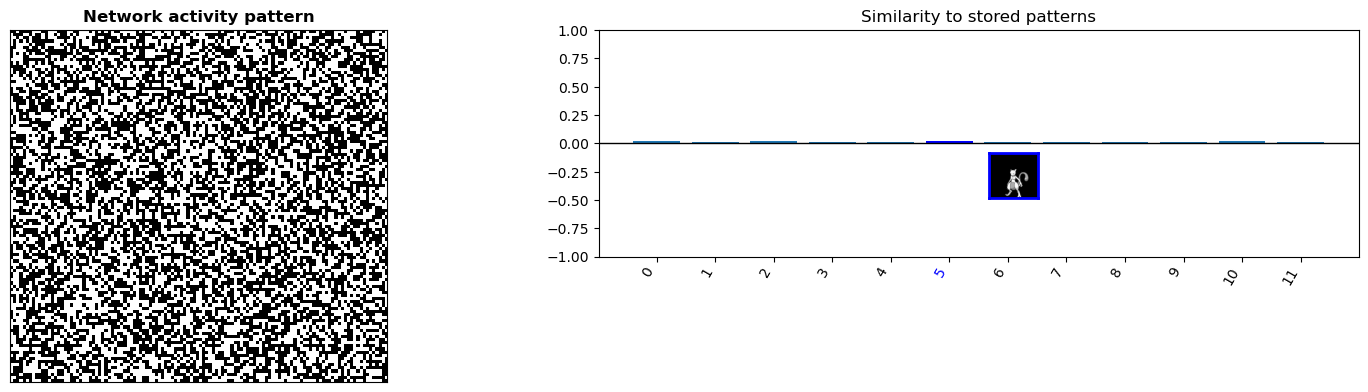

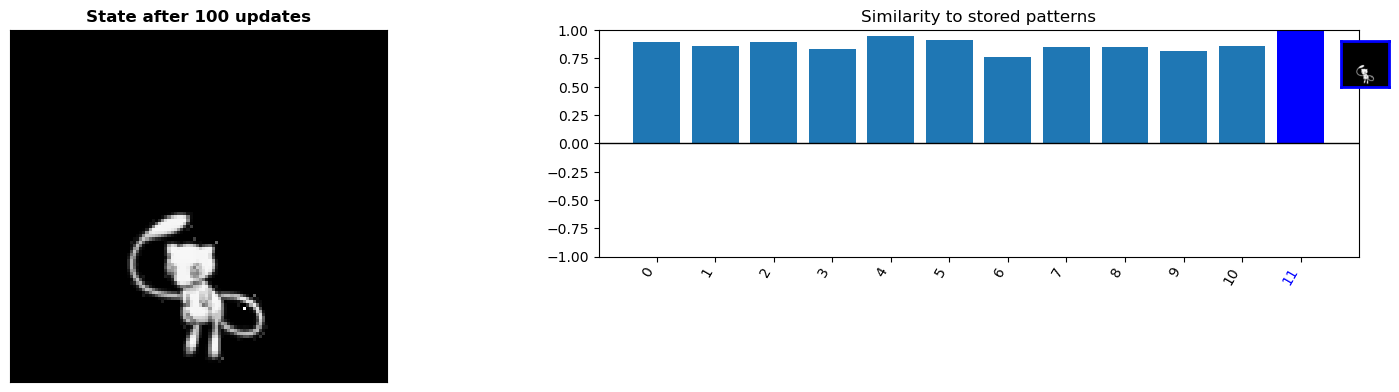

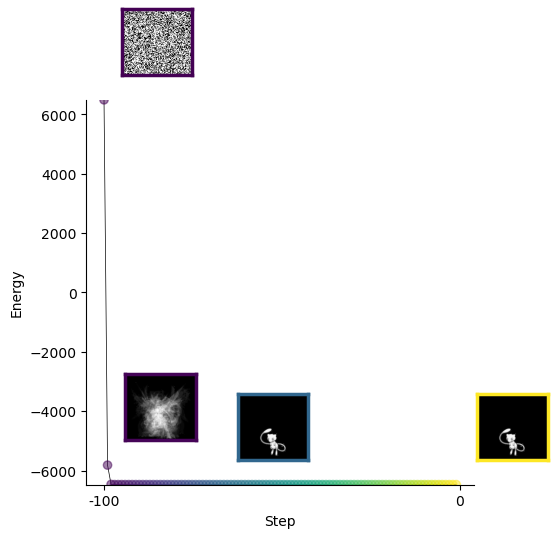

In [1143]:
MHFN = ModernHopfieldNetwork(patterns)
MHFN.set_state(random=True)
MHFN.visualise()
for i in range (n_updates):
    MHFN.update_state()
MHFN.visualise(title=f"State after {n_updates} updates")
MHFN.plot_energy(n_steps=100)
plt.show()

# Exercise 6.15

Like you did previously with simple patterns, show that our new Hopfield Network is able to recognize images even when they are noisy or when a large portion of the image is hidden/masked.


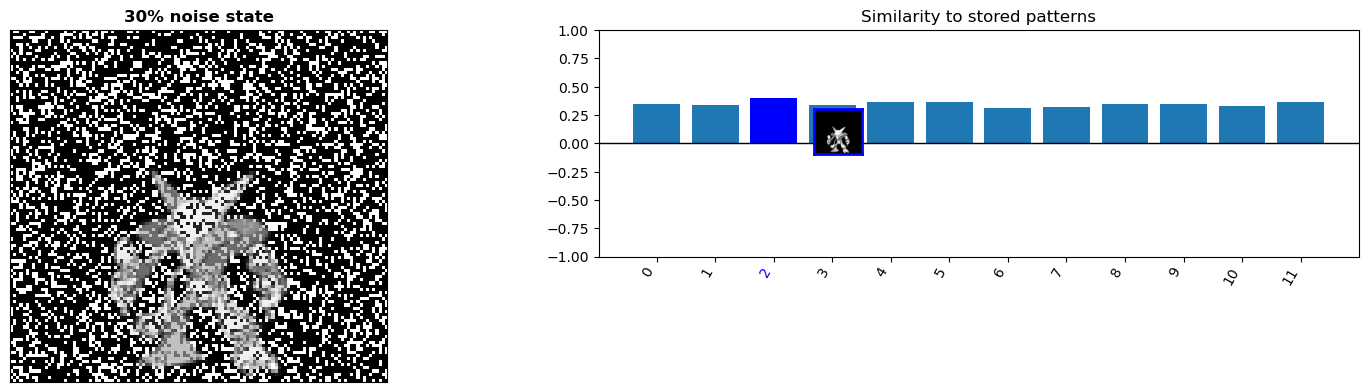

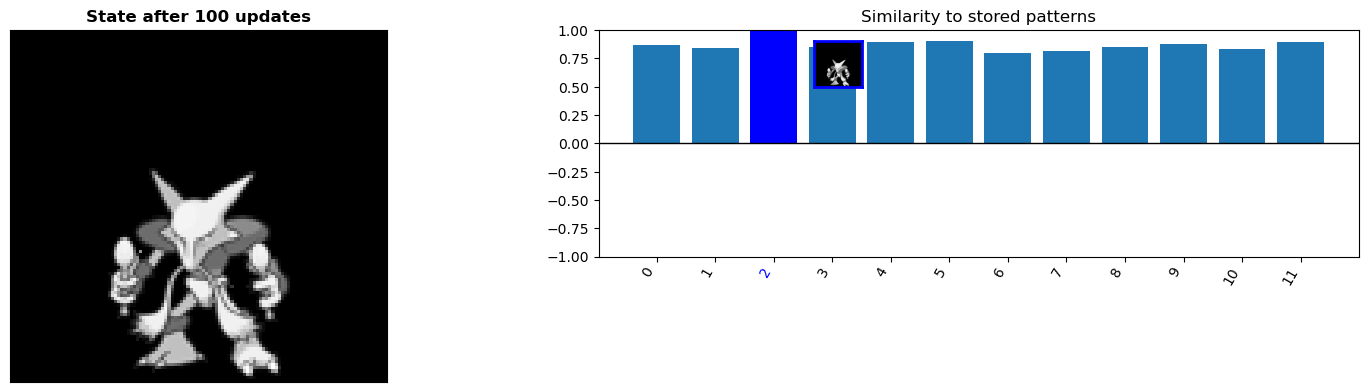

In [1145]:
### START WITH THE NOISY PATTERN...

pattern_to_start = patterns[np.random.choice(list(patterns.keys()))] #prendo un pattern a caso

X = 30 # percentage of bits to flip 

noisy_pattern = pattern_to_start.copy()
apply_noise(noisy_pattern, percentage=X)

#reinitialise the state of the network, evolve it for several steps and then visualise 

MHFN=ModernHopfieldNetwork(patterns)
MHFN.set_state(noisy_pattern.flatten())
MHFN.visualise(title=f"{X}% noise state")
for i in range(n_updates):
    MHFN.update_state()

MHFN.visualise(title=f"State after {n_updates} updates")
plt.show()



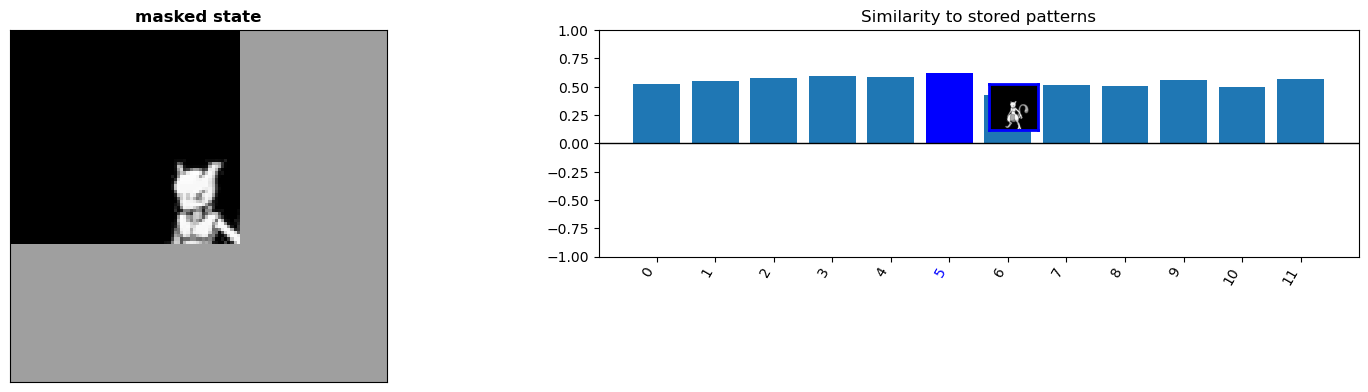

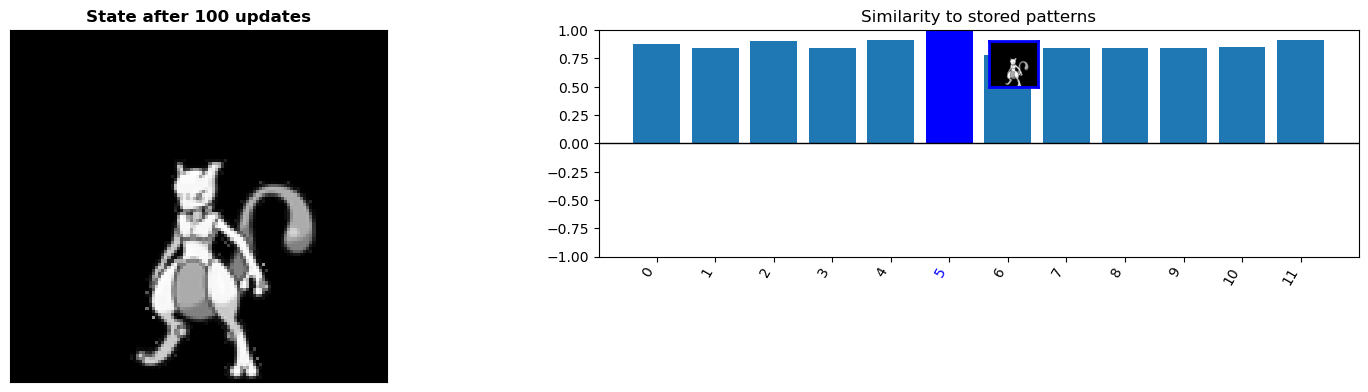

In [1151]:
### ... NOW DO THE SAME WITH THE MASKED PATTERN

pattern_to_start = patterns[np.random.choice(list(patterns.keys()))] #prendo un pattern a caso

masked = apply_mask(pattern_to_start,mask_amount=40)

#reinitialise the state of the network, evolve it for several steps and then visualise 

MHFN=ModernHopfieldNetwork(patterns)

MHFN.set_state(masked.flatten())

MHFN.visualise(title="masked state")
for i in range(n_evolutions):
    MHFN.update_state()
MHFN.visualise(title=f"State after {i+1} updates")
plt.show()

# Exercise 6.16

In the update function for the Modern Hopfield Network we use a scalar quantity called $\beta$, a sort of inverse temperature.

Try to evolve a random state with the Modern Hopfield Network using a very high temperature, for instance $\beta \leftarrow 0.001$. What do you see?

If everything you did is correct, you should see that at high temperature the network evolves towards metastable states. Can you briefly explain why you see this behaviour?



The network with high temperature converges into a metastable state, which is a local minimum of the energy function of the system. This occurs because, for lower beta, the "thermal noise" becomes more strong and the network fails to recognize one pattern among all the stored ones. Mathematically, the issue lies in the update rule: the softmax function turns the data in to a normalized probability distribution. Therefore, if the input values are very small (which happens for lower beta) the softmax tends to return an uniform distribution over the states. This means that the network will find it more difficult to converge to a precise state and will instead become trapped into a mixture of the stored patterns.

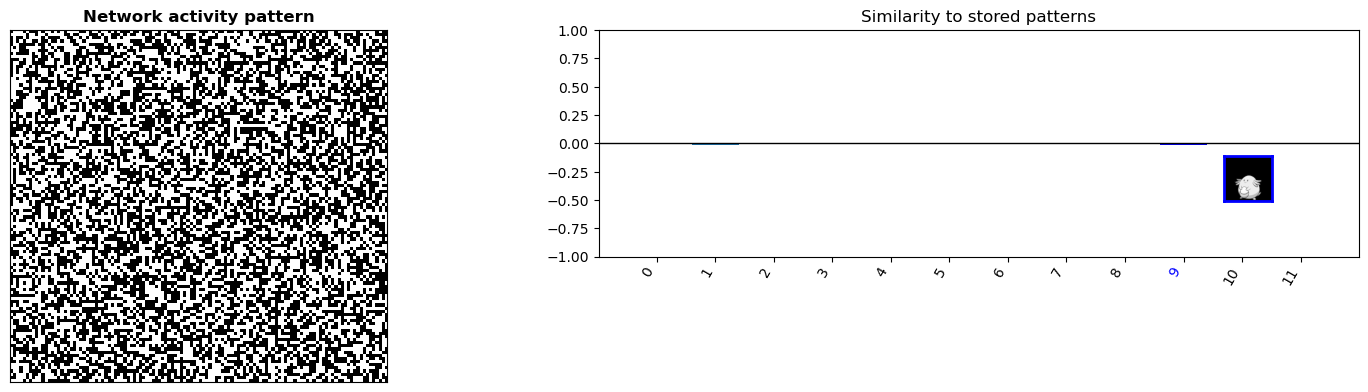

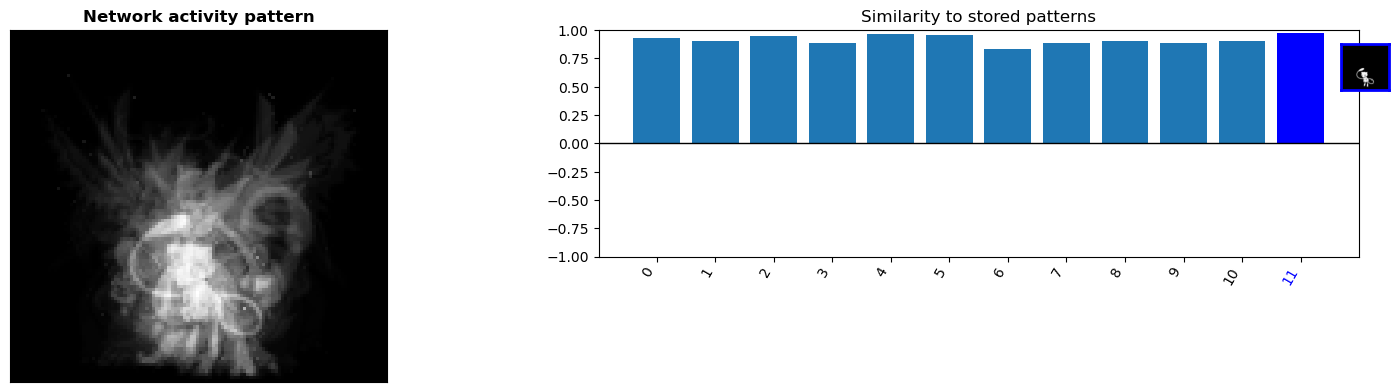

In [1155]:

MHFN=ModernHopfieldNetwork(patterns, beta=0.001)

MHFN.set_state(random= True)


MHFN.visualise()
for i in range(n_evolutions):
    MHFN.update_state()

MHFN.visualise()
plt.show()